# Association/dissociation kinetics

In [1]:
import numpy as np
import pandas as pd
from pyroapi import handlers, infer, pyro, pyro_backend
from pyro import distributions as dist
from pyro.ops.stats import pi
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path

from tapqir.models import Cosmos
from tapqir.utils.imscroll import association_rate, dissociation_rate

## Load results

In [2]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [3]:
truth = {}
fit = {}
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("kon"):
        # load simulated values
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        # load fitting results
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs32/"
        fit[data_path.name] = pd.read_csv(
            param_path / "statistics.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["kon"] = truth[data_path.name]["kon"]
        fit[data_path.name]["lamda"] = truth[data_path.name]["lamda"]
        
        # rate constants
        model = Cosmos()
        model.load(data_path, True)
        model.load_parameters(param_path)
        z_samples = (model.theta_samples > 0).long()
        # kon distribtion (MLE fit)
        kon_samples = association_rate(z_samples)
        fit[data_path.name]["kon_mean"] = kon_samples.mean().item()
        fit[data_path.name]["kon_ll"], fit[data_path.name]["kon_ul"] = pi(kon_samples, 0.95, dim=0)
        # koff distribution (MLE fit)
        koff_samples = dissociation_rate(z_samples)
        fit[data_path.name]["koff_mean"] = koff_samples.mean().item()
        fit[data_path.name]["koff_ll"], fit[data_path.name]["koff_ul"] = pi(koff_samples, 0.95, dim=0)

In [4]:
truth_df = pd.concat(truth.values(), axis=1).T.astype(float)
truth_df["Keq"] = truth_df["kon"] / truth_df["koff"]
truth_df = truth_df.sort_values(by=["kon", "lamda"])
truth_df

,width,gain,kon,koff,lamda,proximity,offset,height,background,snr,N,F,Nc,Fc,P,Keq
kon0.01lamda0.01,1.4,7.0,0.01,0.2,0.01,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.05
kon0.01lamda0.15,1.4,7.0,0.01,0.2,0.15,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.05
kon0.01lamda0.5,1.4,7.0,0.01,0.2,0.50,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.05
kon0.01lamda1,1.4,7.0,0.01,0.2,1.00,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.05
kon0.02lamda0.01,1.4,7.0,0.02,0.2,0.01,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.10
kon0.02lamda0.15,1.4,7.0,0.02,0.2,0.15,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.10
kon0.02lamda0.5,1.4,7.0,0.02,0.2,0.50,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.10
kon0.02lamda1,1.4,7.0,0.02,0.2,1.00,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.10
kon0.03lamda0.01,1.4,7.0,0.03,0.2,0.01,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.15
kon0.03lamda0.15,1.4,7.0,0.03,0.2,0.15,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.15


In [5]:
fit_df = pd.concat(fit.values(), axis=1).T.sort_values(by=["kon", "lamda"])
fit_df["converged"]

kon0.01lamda0.01    True
kon0.01lamda0.15    True
kon0.01lamda0.5     True
kon0.01lamda1       True
kon0.02lamda0.01    True
kon0.02lamda0.15    True
kon0.02lamda0.5     True
kon0.02lamda1       True
kon0.03lamda0.01    True
kon0.03lamda0.15    True
kon0.03lamda0.5     True
kon0.03lamda1       True
Name: converged, dtype: object

In [6]:
fit_df = fit_df.drop(columns=["converged"]).astype(float)
fit_df

,snr,gain_mean,gain_ll,gain_ul,pi_mean,pi_ll,pi_ul,lamda_mean,lamda_ll,lamda_ul,...,p(specific)_ll,p(specific)_ul,kon,lamda,kon_mean,kon_ll,kon_ul,koff_mean,koff_ll,koff_ul
kon0.01lamda0.01,3.761326,7.016907,7.013943,7.019773,0.045444,0.043977,0.046995,0.010038,0.009533,0.010493,...,0.99700,1.000,0.01,0.01,0.010447,0.010288,0.010606,0.219238,0.216483,0.221955
kon0.01lamda0.15,3.778336,7.039374,7.036456,7.042323,0.045004,0.043391,0.046806,0.151202,0.149604,0.152805,...,0.96400,0.994,0.01,0.15,0.012544,0.012300,0.012775,0.267763,0.262404,0.272953
kon0.01lamda0.5,3.811583,7.037618,7.034414,7.040583,0.044546,0.043325,0.045802,0.495349,0.492558,0.498317,...,0.86400,0.980,0.01,0.50,0.016058,0.015752,0.016354,0.356137,0.348516,0.363236
kon0.01lamda1,3.858114,7.072536,7.069291,7.075689,0.041208,0.039802,0.042585,0.969468,0.965150,0.973634,...,0.70136,0.965,0.01,1.00,0.018878,0.018511,0.019221,0.436238,0.427146,0.445274
kon0.02lamda0.01,3.757183,7.021191,7.017925,7.024334,0.086190,0.084559,0.087994,0.010070,0.009633,0.010535,...,0.99800,1.000,0.02,0.01,0.020620,0.020388,0.020858,0.217971,0.216015,0.219904
kon0.02lamda0.15,3.781136,7.031673,7.028571,7.035212,0.085201,0.083095,0.087020,0.151003,0.149228,0.152705,...,0.98100,0.997,0.02,0.15,0.023340,0.023053,0.023619,0.251042,0.248004,0.254047
kon0.02lamda0.5,3.818364,7.053596,7.050346,7.056524,0.083691,0.082134,0.085265,0.496101,0.493366,0.498859,...,0.92760,0.990,0.02,0.50,0.028045,0.027690,0.028410,0.313915,0.309631,0.318539
kon0.02lamda1,3.859950,7.082096,7.078966,7.085494,0.079563,0.077990,0.081075,0.964220,0.960266,0.968455,...,0.82800,0.982,0.02,1.00,0.032139,0.031722,0.032556,0.374533,0.369233,0.379734
kon0.03lamda0.01,3.755211,7.015100,7.012075,7.018276,0.128722,0.126669,0.130850,0.010295,0.009749,0.010786,...,0.99900,1.000,0.03,0.01,0.031711,0.031413,0.032026,0.213017,0.211462,0.214661
kon0.03lamda0.15,3.779948,7.040715,7.037868,7.043923,0.127198,0.124702,0.129677,0.150728,0.149189,0.152320,...,0.98700,0.999,0.03,0.15,0.034814,0.034462,0.035169,0.237888,0.235681,0.240227


In [7]:
description = pd.Series(dtype=str, name="Description")
description["N"] = "Number of on-target AOIs"
description["F"] = "Number of frames for on-target AOIs"
description["Nc"] = "Number of control off-target AOIs"
description["Fc"] = "Number of frames for off-target AOIs"
description["P"] = "Number of pixels along x- and y-axes of an AOI"
description["height"] = "Spot intensity"
description["width"] = "Spot width"
description["snr"] = "Signal-to-noise ratio"
description["background"] = "Image background"
description["pi"] = "Average target-specific binding probability"
description["lamda"] = "Non-specific binding rate"
description["proximity"] = "Proximity parameter"
description["p(specific)"] = "Probability of there being any target-specific spot in an AOI image"
description["_ul"] = "95% CI upper-limit"
description["_ll"] = "95% CI lower-limit"
description["MCC"] = "Matthews correlation coefficient"
description["TP"] = "True positives"
description["FN"] = "False negatives"
description["TN"] = "True negatives"
description["FP"] = "False positives"
description

N                                       Number of on-target AOIs
F                            Number of frames for on-target AOIs
Nc                             Number of control off-target AOIs
Fc                          Number of frames for off-target AOIs
P                 Number of pixels along x- and y-axes of an AOI
height                                            Spot intensity
width                                                 Spot width
snr                                        Signal-to-noise ratio
background                                      Image background
pi                   Average target-specific binding probability
lamda                                  Non-specific binding rate
proximity                                    Proximity parameter
p(specific)    Probability of there being any target-specific...
_ul                                           95% CI upper-limit
_ll                                           95% CI lower-limit
MCC                      

## Supplementary Data 5

In [8]:
with pd.ExcelWriter("/home/ordabayev/repos/tapqir-overleaf/supplementary/data5/kinetic.xlsx") as writer:
    truth_df.to_excel(writer, sheet_name="simulation")
    fit_df.to_excel(writer, sheet_name="fit")
    description.to_excel(writer, sheet_name="description")

## Figure 6

### Keq

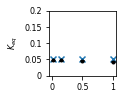

In [8]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.01)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "Keq"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], fit_df.loc[mask, "Keq_mean"],
             yerr=abs(fit_df.loc[mask, ["Keq_ll", "Keq_ul"]].values.T-fit_df.loc[mask, "Keq_mean"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
ax.set_ylim(0, 0.2)
ax.set_xlim(-0.05, 1.05)
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
plt.ylabel(r"$K_{eq}$", fontsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/keq1.svg")
plt.show()

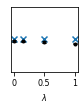

In [9]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.02)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "Keq"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], fit_df.loc[mask, "Keq_mean"],
             yerr=abs(fit_df.loc[mask, ["Keq_ll", "Keq_ul"]].values.T-fit_df.loc[mask, "Keq_mean"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
ax.set_ylim(0, 0.2)
ax.set_xlim(-0.05, 1.05)
ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel(r"$\lambda$", fontsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/keq2.svg")
plt.show()

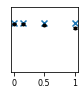

In [10]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.03)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "Keq"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], fit_df.loc[mask, "Keq_mean"],
             yerr=abs(fit_df.loc[mask, ["Keq_ll", "Keq_ul"]].values.T-fit_df.loc[mask, "Keq_mean"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
ax.set_ylim(0, 0.2)
ax.set_xlim(-0.05, 1.05)
ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/keq3.svg")
plt.show()

### kon

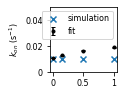

In [11]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.01)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "kon"], marker="x", label="simulation")
plt.errorbar(truth_df.loc[mask, "lamda"], fit_df.loc[mask, "kon_mean"],
             yerr=abs(fit_df.loc[mask, ["kon_ll", "kon_ul"]].values.T-fit_df.loc[mask, "kon_mean"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
ax.set_ylim(0, 0.05)
ax.set_xlim(-0.05, 1.05)
# ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_ylabel(r"$k_{on}$ (s$^{-1}$)", fontsize=8)
plt.legend(fontsize=8)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/kon1.svg")
plt.show()

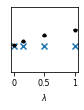

In [12]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.02)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], fit_df.loc[mask, "kon_mean"],
             yerr=abs(fit_df.loc[mask, ["kon_ll", "kon_ul"]].values.T-fit_df.loc[mask, "kon_mean"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
ax.set_ylim(0, 0.05)
ax.set_xlim(-0.05, 1.05)
ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_xlabel(r"$\lambda$", fontsize=8)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/kon2.svg")
plt.show()

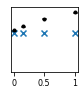

In [13]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.03)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], fit_df.loc[mask, "kon_mean"],
             yerr=abs(fit_df.loc[mask, ["kon_ll", "kon_ul"]].values.T-fit_df.loc[mask, "kon_mean"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
ax.set_ylim(0, 0.05)
ax.set_xlim(-0.05, 1.05)
ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/kon3.svg")
plt.show()

### koff

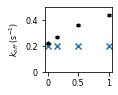

In [14]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.01)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], fit_df.loc[mask, "koff_mean"],
             yerr=abs(fit_df.loc[mask, ["koff_ll", "koff_ul"]].values.T-fit_df.loc[mask, "koff_mean"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
ax.set_ylim(0, 0.5)
ax.set_xlim(-0.05, 1.05)
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_ylabel(r"$k_{off}$ (s$^{-1}$)", fontsize=8)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/koff1.svg")
plt.show()

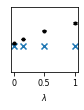

In [15]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.02)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], fit_df.loc[mask, "koff_mean"],
             yerr=abs(fit_df.loc[mask, ["koff_ll", "koff_ul"]].values.T-fit_df.loc[mask, "koff_mean"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
ax.set_ylim(0, 0.5)
ax.set_xlim(-0.05, 1.05)
ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_xlabel(r"$\lambda$", fontsize=8)
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/koff2.svg")
plt.show()

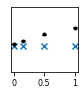

In [16]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.03)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], fit_df.loc[mask, "koff_mean"],
             yerr=abs(fit_df.loc[mask, ["koff_ll", "koff_ul"]].values.T-fit_df.loc[mask, "koff_mean"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
ax.set_ylim(0, 0.5)
ax.set_xlim(-0.05, 1.05)
ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/koff3.svg")
plt.show()

### Traces

In [17]:
model = Cosmos()
model.load(EXAMLES_DIR / "kon0.02lamda1", True)
model.load_parameters(EXAMLES_DIR / "kon0.02lamda1" / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs32/")
z_samples = (model.theta_samples > 0).long()

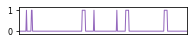

In [18]:
plt.figure(figsize=(3, 0.5))

n = 4
f1 = 0
f2 = 300
plt.plot(
    torch.arange(f1, f2),
    model.data.labels["z"][n, f1:f2],
    "-", lw=1, color="C4", label="simulation")

plt.xticks([], fontsize=8)
plt.yticks([0, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/simulation.svg")
plt.show()

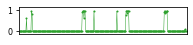

In [19]:
plt.figure(figsize=(3, 0.5))

plt.plot(
    torch.arange(f1, f2),
    model.z_marginal[n, f1:f2],
    "o-", ms=1, lw=0.5, color="C2", label="fit")

plt.xticks([], fontsize=8)
plt.yticks([0, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/pspecific.svg")
plt.show()

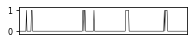

In [20]:
plt.figure(figsize=(3, 0.5))

plt.plot(
    torch.arange(f1, f2),
    z_samples[5, n, f1:f2],
    "-", ms=2, lw=0.5, color="k", label="fit")

plt.xticks([], fontsize=8)
plt.yticks([0, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/sample1.svg")
plt.show()

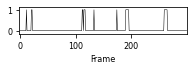

In [21]:
plt.figure(figsize=(3, 0.5))

plt.plot(
    torch.arange(f1, f2),
    z_samples[1, n, f1:f2],
    "-", ms=2, lw=0.5, color="k", label="fit")

plt.xticks(fontsize=8)
plt.yticks([0, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.xlabel("Frame", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

# plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/sample2.svg")
plt.show()